In [10]:
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette="pastel")
%matplotlib inline


from sklearn.cluster import KMeans

import cv2
import glob
import csv

import warnings
warnings.filterwarnings('ignore')

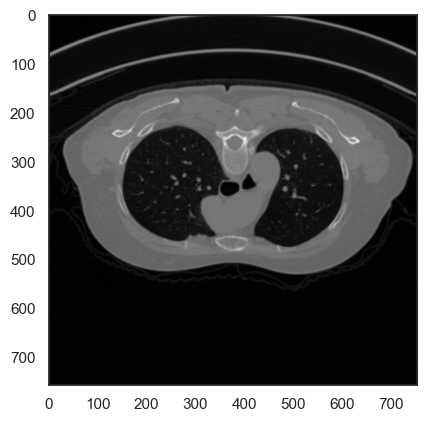

In [2]:
exam_path = 'c:/csv/medical/slice001.png'
image = cv2.imread(exam_path)
plt.imshow(image);
#Radiografiade um pulmão
#a ideia é fazer uma segmentação da imagem
#dividir a imagem pra analisar a area de interesse

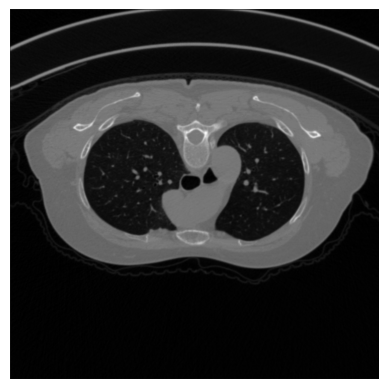

In [3]:
#tratando a imagem para transformar em objeto para o opencv
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = "gray");
plt.axis('off');

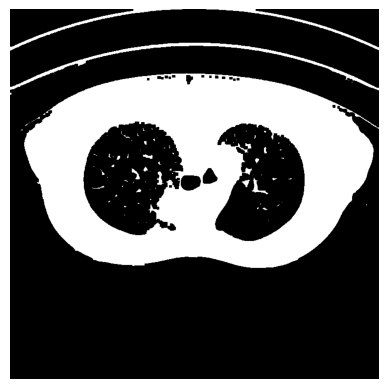

In [4]:
#definindo a imagem em apenas 2 tons(Branco e preto)
_ , mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((5, 5), np.uint8))
plt.imshow(mask, cmap = "gray")
plt.axis('off')
cv2.imwrite('c:/csv/medical/thresholding.png', cv2.hconcat([image, np.stack((mask, mask, mask), axis=2)]));

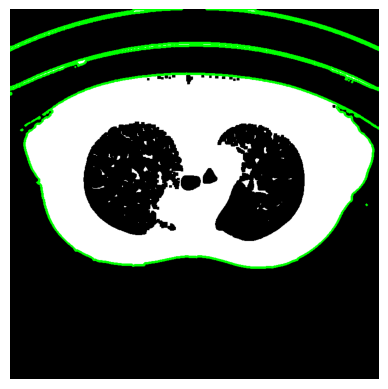

In [5]:
#encontrando os contornos da imagem
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#contornos = linha verde
contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off');

#é observado que a parte interna do pulmão n ta sendo reconhecida

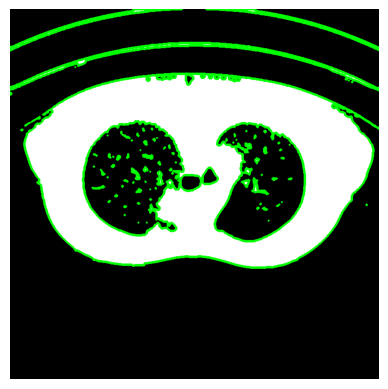

In [6]:
#alterando o parametro pra RETR_TREE para encontrar todos os contornos até os internos
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off');

In [8]:
#encontrando o contorno
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    sz=4000 #parametro de area
    if (area > sz) & (area < 20*sz):#definindo parametro pra contorno, se não corresponder o parametro é descartado
        filtered_contours.append(contour)
      
        masked = np.zeros_like(image[:, :, 0])  
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

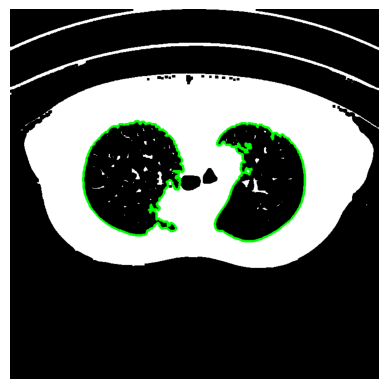

In [9]:
#gerando nova imagem que atenda os parametros definidos na função anterior
contours_img_after_filtering = mask.copy()
contours_img_after_filtering = cv2.cvtColor(contours_img_after_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_after_filtering, tuple(filtered_contours), -1, (0, 255, 0), 3)

plt.imshow(contours_img_after_filtering)
plt.axis('off')

cv2.imwrite('./data/medical/contours.png', cv2.hconcat([contours_img_before_filtering, contours_img_after_filtering]));

In [11]:
#utilizandoo kmeans pra separar a imagem em partes
km = KMeans(n_clusters=2) #separando em 2 imagens
df_mean_color['label'] = km.fit_predict(df_mean_color)

In [12]:
#Função pra segmentar a imagem
def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} bubbles', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

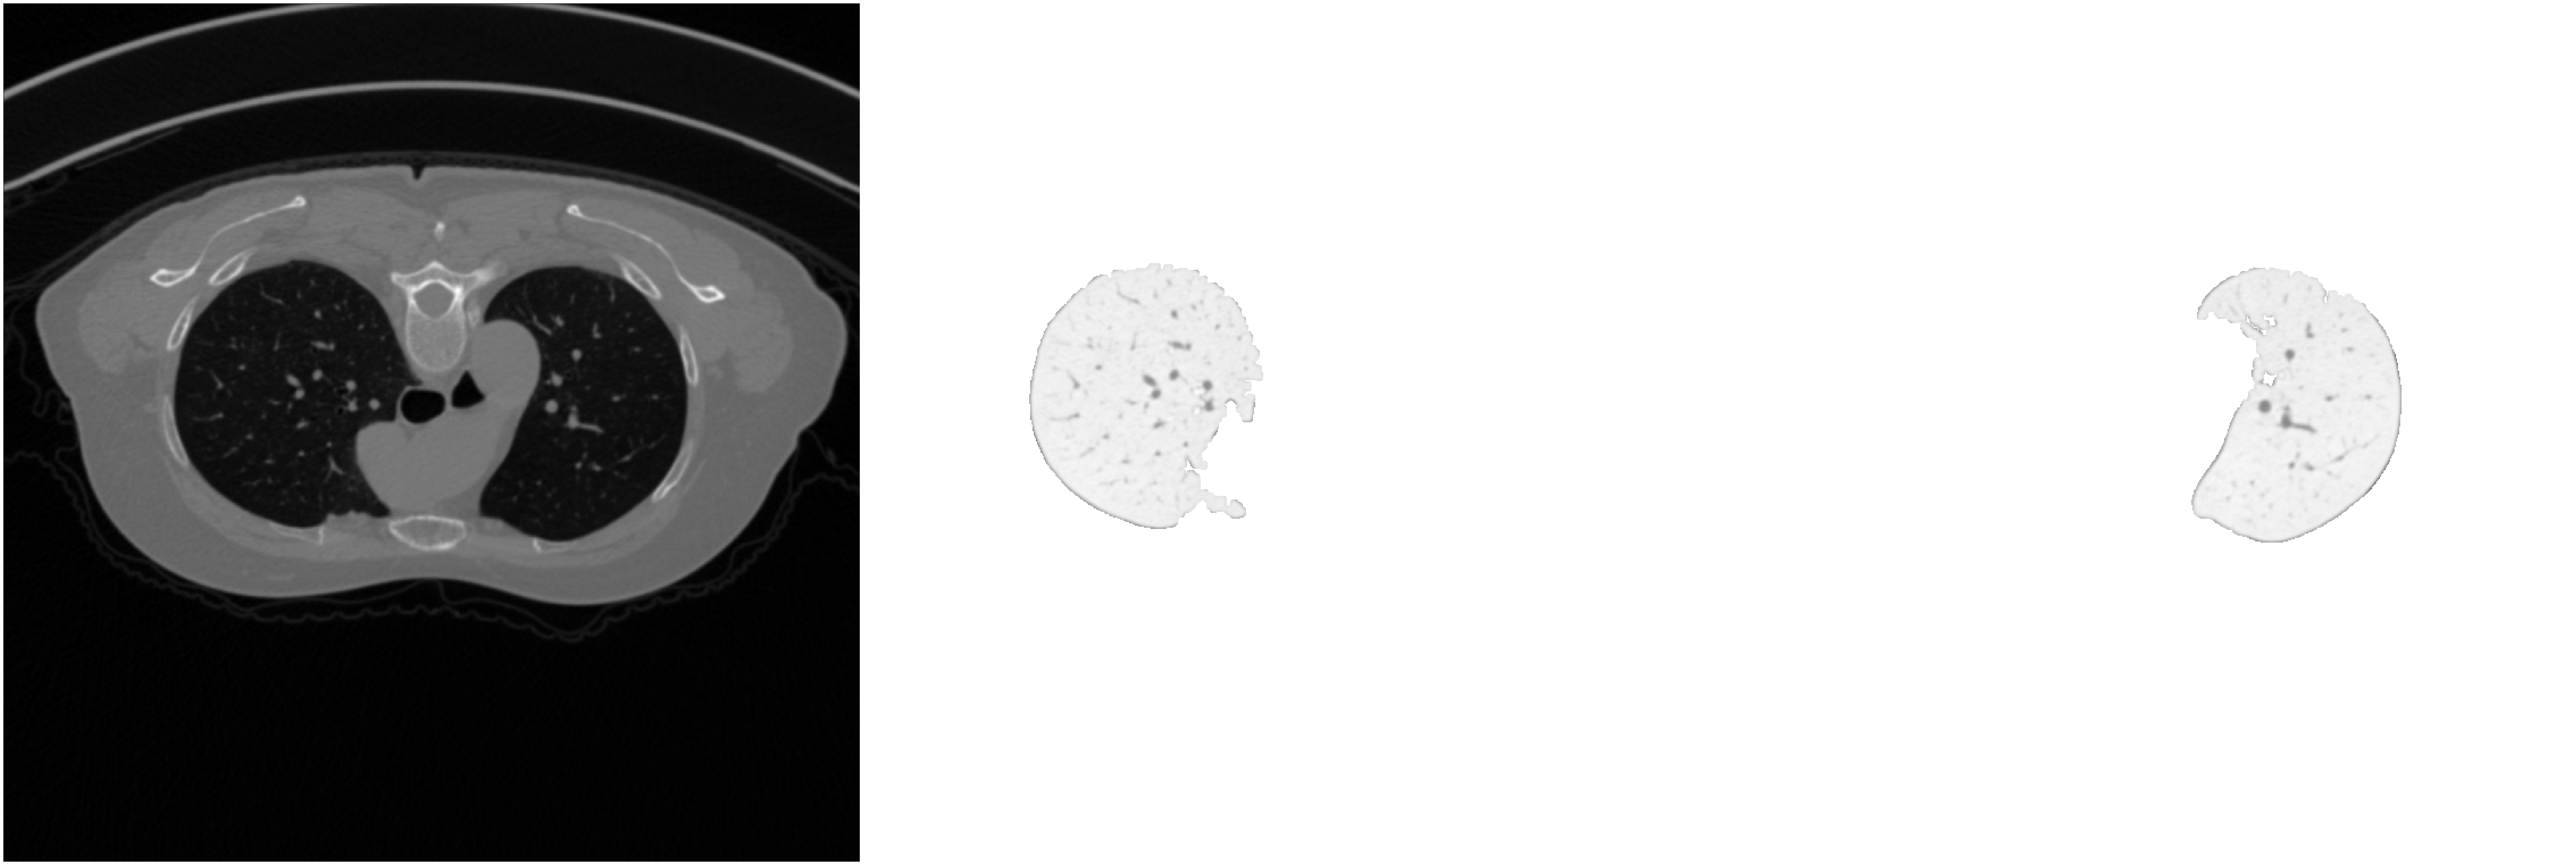

In [13]:
img = image.copy()
plt.figure(figsize = (100,40))
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
    temp = np.invert(masked_image)
    img = cv2.hconcat([img, temp])
    

cv2.imwrite('./data/medical/color_segmentation.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off');

#a imagem original e a segmentação dos 2 pulmões

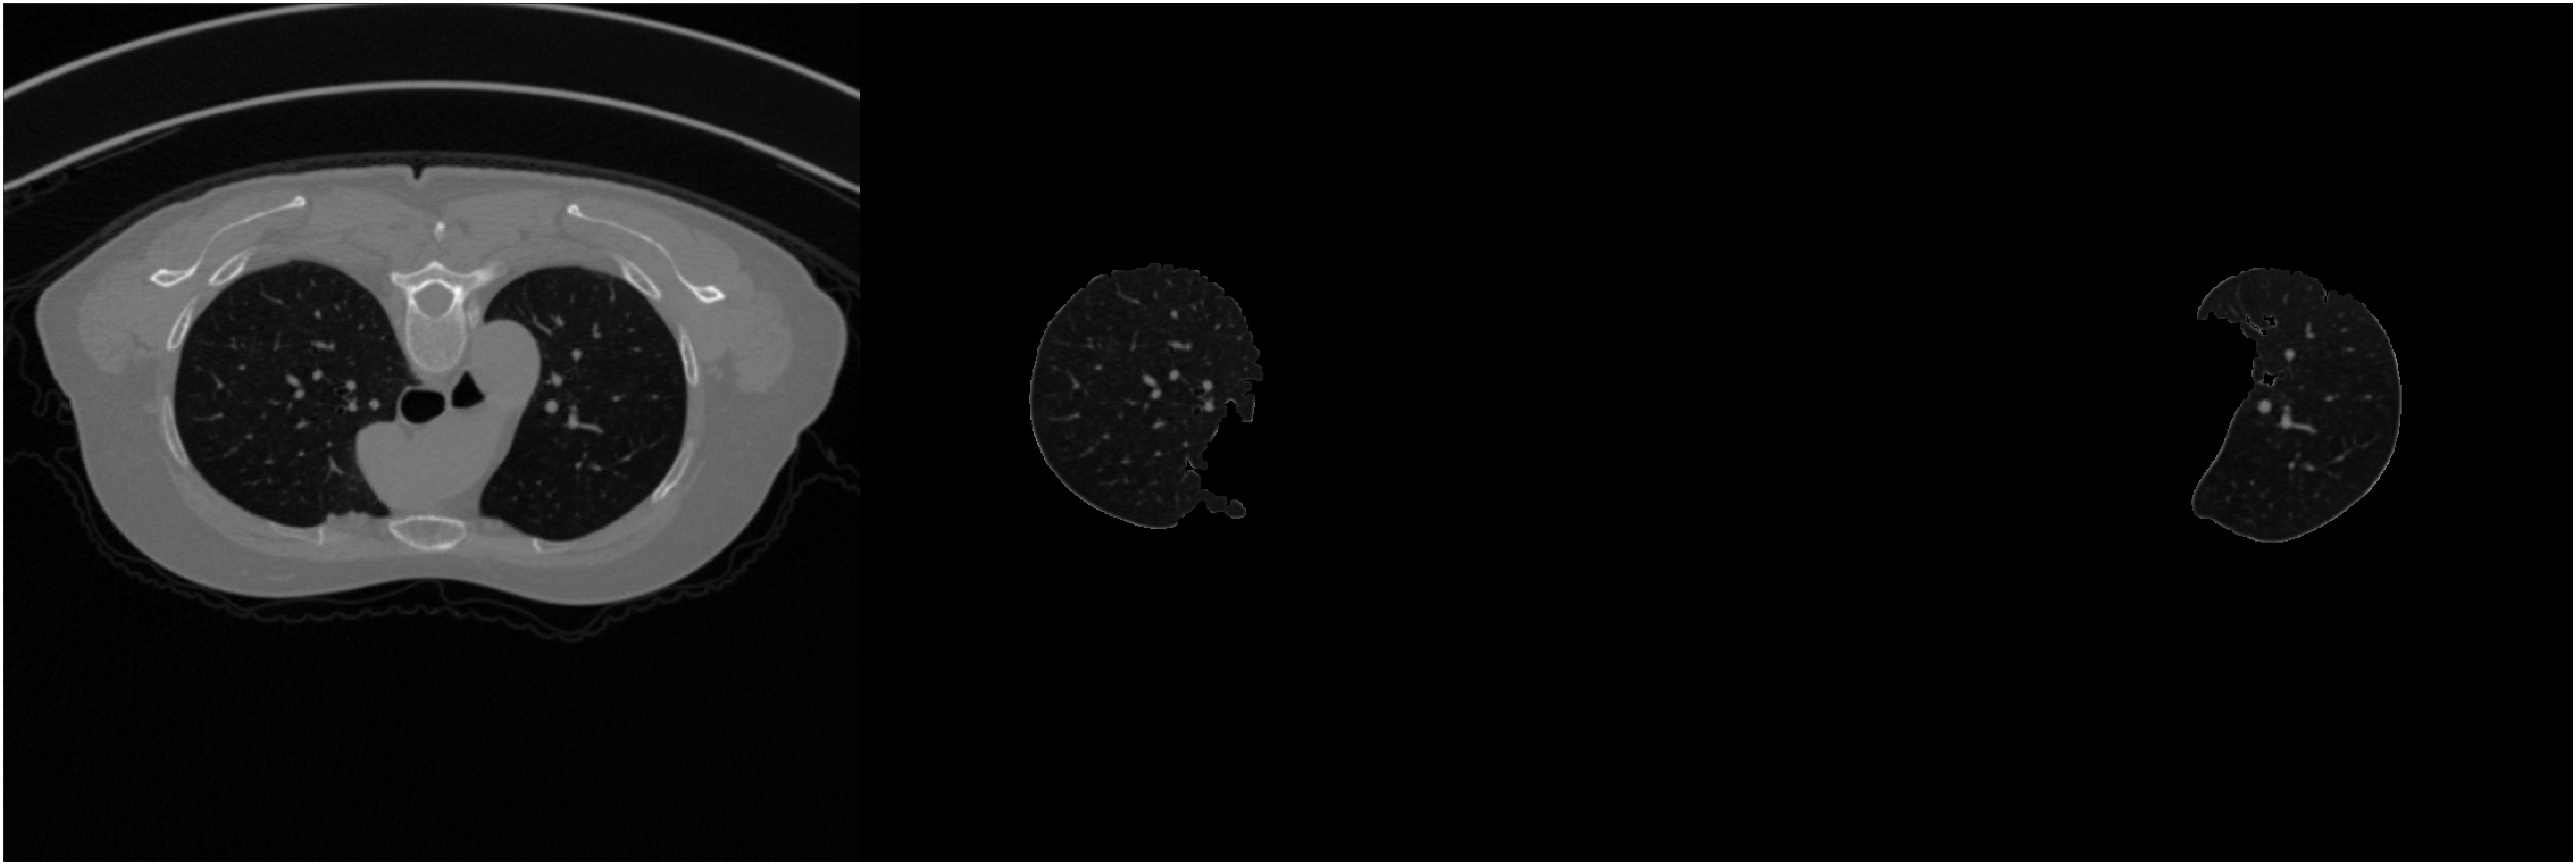

In [14]:
#mudando para a cor original

img = image.copy()
plt.figure(figsize = (100,40))
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
    #temp = np.invert(masked_image)
    img = cv2.hconcat([img, masked_image])
    

cv2.imwrite('./data/medical/color_segmentation.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off');

#segmentando permite aplicar outras mascaras de imagem pra aplicar cores e ver se é possivel encontrar pontos que façam sentido